In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [38]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

In [39]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [40]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a *pandas* dataframe

In [41]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [42]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [43]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(manhattan_data['Borough'].unique()),
        manhattan_data.shape[0]))
manhattan_data.head()

The dataframe has 1 boroughs and 40 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [44]:
address = 'Manhattan, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


In [45]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [46]:
CLIENT_ID = 'ELP0R2RIC1LSEUB5OYT4XITO3HKU10LEHNLOPD3QTA3PR3W4' # your Foursquare ID
CLIENT_SECRET = 'PXWBO1OEDGXVLN1BDBLKOVQ0JIH0PUGU554USUVIXC0QUPC2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ELP0R2RIC1LSEUB5OYT4XITO3HKU10LEHNLOPD3QTA3PR3W4
CLIENT_SECRET:PXWBO1OEDGXVLN1BDBLKOVQ0JIH0PUGU554USUVIXC0QUPC2


## 2. Explore Neighborhoods in Manhattan

In [ ]:
#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [53]:
CLIENT_ID = 'ELP0R2RIC1LSEUB5OYT4XITO3HKU10LEHNLOPD3QTA3PR3W4' # your Foursquare ID
CLIENT_SECRET = 'PXWBO1OEDGXVLN1BDBLKOVQ0JIH0PUGU554USUVIXC0QUPC2' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    latitude, 
    longitude, 
    VERSION, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=ELP0R2RIC1LSEUB5OYT4XITO3HKU10LEHNLOPD3QTA3PR3W4&client_secret=PXWBO1OEDGXVLN1BDBLKOVQ0JIH0PUGU554USUVIXC0QUPC2&ll=40.7900869,-73.9598295&v=20180604&radius=500&limit=500'

In [54]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION,  
            radius, 
            LIMIT)
            
        # make the GET reques
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
 

In [ ]:
#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [55]:
# type your answer here
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'])

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [56]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3313, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant


In [57]:
manhattan_restaurant_venues = manhattan_venues[manhattan_venues["Venue Category"].str.contains('Restaurant')].reset_index(drop=True)
print(manhattan_restaurant_venues.shape)
manhattan_restaurant_venues.head()

(938, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant
1,Marble Hill,40.876551,-73.910660,Boston Market,40.877430,-73.905412,American Restaurant
2,Chinatown,40.715618,-73.994279,Spicy Village 大福星 (Spicy Village),40.717010,-73.993530,Chinese Restaurant
3,Chinatown,40.715618,-73.994279,Kiki's,40.714476,-73.992036,Greek Restaurant
4,Chinatown,40.715618,-73.994279,The Fat Radish,40.715323,-73.991950,English Restaurant


In [58]:
restaurant_count = manhattan_restaurant_venues.groupby("Venue Category").size()
restaurant_count = pd.DataFrame(restaurant_count)
restaurant_count.columns = ['Restaurant_Count']
restaurant_count.sort_values('Restaurant_Count', ascending=False, inplace=True)
restaurant_count

,Restaurant_Count
Venue Category,
Italian Restaurant,136
American Restaurant,77
Mexican Restaurant,58
French Restaurant,57
Sushi Restaurant,47
Chinese Restaurant,46
Japanese Restaurant,43
Seafood Restaurant,40
Indian Restaurant,30


Let's check how many venues were returned for each neighborhood

In [59]:
manhattan_restaurant_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,10,10,10,10,10,10
Carnegie Hill,26,26,26,26,26,26
Central Harlem,14,14,14,14,14,14
Chelsea,26,26,26,26,26,26
Chinatown,41,41,41,41,41,41
Civic Center,23,23,23,23,23,23
Clinton,21,21,21,21,21,21
East Harlem,15,15,15,15,15,15
East Village,40,40,40,40,40,40


#### Let's find out how many unique categories can be curated from all the returned venues

In [60]:
print('There are {} uniques categories.'.format(len(manhattan_restaurant_venues['Venue Category'].unique())))

There are 75 uniques categories.


<a id='item3'></a>

In [61]:
print (manhattan_venues['Venue Category'].unique())

['Pizza Place' 'Yoga Studio' 'Diner' 'Coffee Shop' 'Seafood Restaurant'
 'Donut Shop' 'Tennis Stadium' 'Gym' 'Department Store' 'Video Game Store'
 'Discount Store' 'Pharmacy' 'Supplement Shop' 'Steakhouse'
 'Ice Cream Shop' 'Shoe Store' 'American Restaurant' 'Bank'
 'Sandwich Place' 'Kids Store' 'Shopping Mall' 'Deli / Bodega'
 'Chinese Restaurant' 'General Entertainment' 'Cocktail Bar'
 'Greek Restaurant' 'English Restaurant' 'Museum' 'Hotel' 'Noodle House'
 'Garden Center' 'Spa' 'Bubble Tea Shop' 'Bar' 'Tea Room' 'Roof Deck'
 'New American Restaurant' 'Indie Movie Theater' 'Salon / Barbershop'
 'Malay Restaurant' 'Furniture / Home Store' 'Hotpot Restaurant'
 'Bike Shop' 'Dim Sum Restaurant' 'Vietnamese Restaurant'
 'Spanish Restaurant' 'Italian Restaurant' 'Historic Site'
 'Asian Restaurant' 'Jewelry Store' 'Organic Grocery' 'Grocery Store'
 'Record Shop' 'Music Venue' 'Nail Salon' 'Cosmetics Shop' 'Snack Place'
 'Dumpling Restaurant' 'Bakery' 'Boutique' "Men's Store"
 'Paper / Offi

## 3. Analyze Each Neighborhood

In [62]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_restaurant_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_restaurant_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [63]:
manhattan_onehot.shape

(938, 76)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [64]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Battery Park City,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Carnegie Hill,0.000000,0.000000,0.038462,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.038462,0.115385,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.076923,0.000000,0.115385,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.038462,0.076923,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.038462,0.038462,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.00000,0.000000,0.076923,0.000000,0.000000,0.000000,0.038462,0.000000,0.076923
2,Central Harlem,0.000000,0.214286,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.071429,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.142857,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Chelsea,0.000000,0.000000,0.153846,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.038462,0.230769,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.

#### Let's confirm the new size

In [65]:
manhattan_grouped.shape

(40, 76)

#### Let's print each neighborhood along with the top 5 most common venues

In [73]:
num_top_venues = 10

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                      venue  freq
0        Italian Restaurant   0.3
1        Seafood Restaurant   0.1
2        Chinese Restaurant   0.1
3        Mexican Restaurant   0.1
4         Indian Restaurant   0.1
5          Sushi Restaurant   0.1
6  Mediterranean Restaurant   0.1
7       American Restaurant   0.1
8        Tibetan Restaurant   0.0
9           Thai Restaurant   0.0


----Carnegie Hill----
                           venue  freq
0            Japanese Restaurant  0.12
1              French Restaurant  0.12
2          Vietnamese Restaurant  0.08
3                Thai Restaurant  0.08
4             Mexican Restaurant  0.08
5             Italian Restaurant  0.08
6            Filipino Restaurant  0.04
7  Vegetarian / Vegan Restaurant  0.04
8               Sushi Restaurant  0.04
9                     Restaurant  0.04


----Central Harlem----
                             venue  freq
0               African Restaurant  0.21
1               Seafood Restaurant  0.14

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [67]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Italian Restaurant,American Restaurant,Indian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Seafood Restaurant,Sushi Restaurant,Chinese Restaurant,Vietnamese Restaurant,French Restaurant
1,Carnegie Hill,French Restaurant,Japanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,American Restaurant,Argentinian Restaurant,Chinese Restaurant
2,Central Harlem,African Restaurant,American Restaurant,French Restaurant,Seafood Restaurant,Chinese Restaurant,Ethiopian Restaurant,Caribbean Restaurant,Southern / Soul Food Restaurant,Falafel Restaurant,Fast Food Restaurant
3,Chelsea,Italian Restaurant,American Restaurant,Seafood Restaurant,Tapas Restaurant,Asian Restaurant,Japanese Restaurant,Sushi Restaurant,New American Restaurant,French Restaurant,Mexican Restaurant
4,Chinatown,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Dim Sum Restaurant,Hotpot Restaurant,Malay Restaurant,Asian Restaurant,Dumpling Restaurant,Shanghai Restaurant,Greek Restaurant
5,Civic Center,Italian Restaurant,French Restaurant,Sushi Restaurant,American Restaurant,Falafel Restaurant,Indian Restaurant,Asian Restaurant,Australian Restaurant,Japanese Restaurant,Mexican Restaurant
6,Clinton,Italian Restaurant,American Restaurant,New American Restaurant,Seafood Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Peruvian Restaurant,Ethiopian Restaurant,Thai Restaurant,Restaurant
7,East Harlem,Mexican Restaurant,Latin American Restaurant,Thai Restaurant,French Restaurant,Restaurant,Cuban Restaurant,Seafood Restaurant,Spanish Restaurant,Vietnamese Restaurant,Ethiopian Restaurant
8,East Village,Mexican Restaurant,Chinese Restaurant,Ramen Restaurant,Vietnamese Restaurant,Italian Restaurant,Filipino Restaurant,Seafood Restaurant,Japanese Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant
9,Financial District,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Falafel Restaurant,Mexican Restaurant,Japanese Curry Restaurant,New American Restaurant,French Restaurant,Cuban Restaurant


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [69]:
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(manhattan_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

In [96]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)

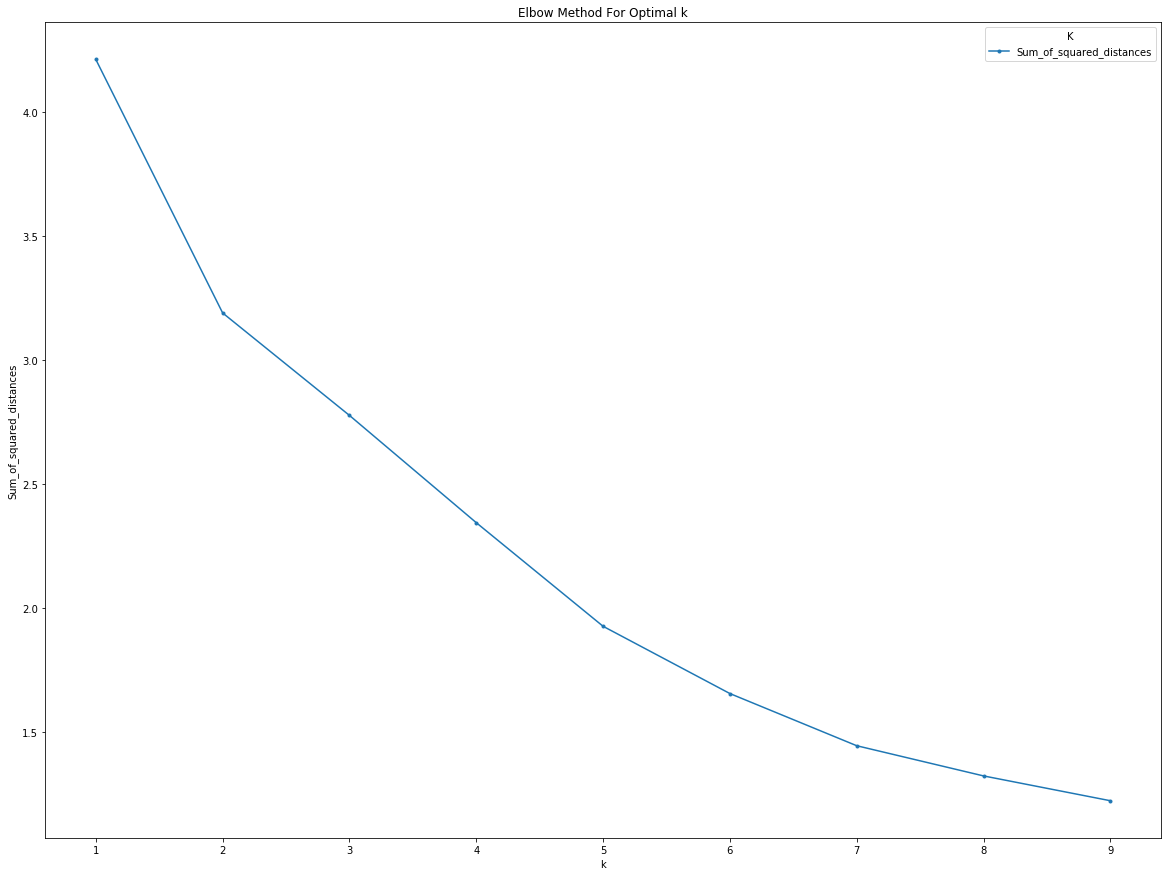

In [97]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
optimal_k.plot(kind = 'line', figsize = (20, 15), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [70]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 0, 2, 0, 0, 2, 2, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [71]:
manhattan_merged = manhattan_data

# add clustering labels
manhattan_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,0,American Restaurant,Seafood Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Dim Sum Restaurant,Hotpot Restaurant,Malay Restaurant,Asian Restaurant,Dumpling Restaurant,Shanghai Restaurant,Greek Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Spanish Restaurant,Latin American Restaurant,Tapas Restaurant,Mexican Restaurant,Caribbean Restaurant,Chinese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Arepa Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,American Restaurant,Restaurant,Chinese Restaurant,Fast Food Restaurant,Latin American Restaurant,Seafood Restaurant,Spanish Restaurant,Caribbean Restaurant,Vietnamese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2,Mexican Restaurant,Chinese Restaurant,Indian Restaurant,Caribbean Restaurant,Japanese Restaurant,Fast Food Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Mediterranean Restaurant


Finally, let's visualize the resulting clusters

In [72]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [49]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,American Restaurant,Seafood Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
3,Inwood,Mexican Restaurant,American Restaurant,Restaurant,Chinese Restaurant,Fast Food Restaurant,Latin American Restaurant,Seafood Restaurant,Spanish Restaurant,Caribbean Restaurant,Vietnamese Restaurant
5,Manhattanville,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Seafood Restaurant,Ramen Restaurant,Indian Restaurant,Falafel Restaurant,Dumpling Restaurant,Cuban Restaurant,Chinese Restaurant
6,Central Harlem,African Restaurant,American Restaurant,French Restaurant,Seafood Restaurant,Chinese Restaurant,Ethiopian Restaurant,Caribbean Restaurant,Southern / Soul Food Restaurant,Falafel Restaurant,Fast Food Restaurant
9,Yorkville,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Sushi Restaurant,Thai Restaurant,Vietnamese Restaurant,German Restaurant,Asian Restaurant,Indian Restaurant,Peruvian Restaurant
10,Lenox Hill,Italian Restaurant,Sushi Restaurant,Mexican Restaurant,Turkish Restaurant,Thai Restaurant,Afghan Restaurant,Spanish Restaurant,Greek Restaurant,Middle Eastern Restaurant,French Restaurant
11,Roosevelt Island,Greek Restaurant,Japanese Restaurant,Gluten-free Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Vietnamese Restaurant
12,Upper West Side,Italian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,American Restaurant,Thai Restaurant,French Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Sushi Restaurant
14,Clinton,Italian Restaurant,American Restaurant,New American Restaurant,Seafood Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Peruvian Restaurant,Ethiopian Restaurant,Thai Restaurant,Restaurant
16,Murray Hill,Italian Restaurant,Japanese Restaurant,French Restaurant,Cuban Restaurant,American Restaurant,Thai Restaurant,Jewish Restaurant,Mediterranean Restaurant,Restaurant,Peruvian Restaurant


#### Cluster 2

In [50]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Battery Park City,Italian Restaurant,American Restaurant,Indian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Seafood Restaurant,Sushi Restaurant,Chinese Restaurant,Vietnamese Restaurant,French Restaurant


#### Cluster 3

In [51]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Dim Sum Restaurant,Hotpot Restaurant,Malay Restaurant,Asian Restaurant,Dumpling Restaurant,Shanghai Restaurant,Greek Restaurant
2,Washington Heights,Spanish Restaurant,Latin American Restaurant,Tapas Restaurant,Mexican Restaurant,Caribbean Restaurant,Chinese Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Arepa Restaurant
4,Hamilton Heights,Mexican Restaurant,Chinese Restaurant,Indian Restaurant,Caribbean Restaurant,Japanese Restaurant,Fast Food Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Mediterranean Restaurant
7,East Harlem,Mexican Restaurant,Latin American Restaurant,Thai Restaurant,French Restaurant,Restaurant,Cuban Restaurant,Seafood Restaurant,Spanish Restaurant,Vietnamese Restaurant,Ethiopian Restaurant
8,Upper East Side,Italian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Sushi Restaurant,Latin American Restaurant,Asian Restaurant,Mediterranean Restaurant,Chinese Restaurant,Seafood Restaurant
13,Lincoln Square,Italian Restaurant,French Restaurant,American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Seafood Restaurant,Chinese Restaurant,Vietnamese Restaurant,German Restaurant,Falafel Restaurant
15,Midtown,American Restaurant,Sushi Restaurant,French Restaurant,Japanese Restaurant,Greek Restaurant,Chinese Restaurant,Fast Food Restaurant,Ramen Restaurant,Indian Restaurant,Mediterranean Restaurant
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,French Restaurant,Indian Restaurant,Chinese Restaurant,Seafood Restaurant,Caribbean Restaurant,Vietnamese Restaurant,American Restaurant,Lebanese Restaurant
19,East Village,Mexican Restaurant,Chinese Restaurant,Ramen Restaurant,Vietnamese Restaurant,Italian Restaurant,Filipino Restaurant,Seafood Restaurant,Japanese Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant
20,Lower East Side,Japanese Restaurant,Chinese Restaurant,Latin American Restaurant,Ramen Restaurant,Italian Restaurant,Mediterranean Restaurant,French Restaurant,Filipino Restaurant,Vietnamese Restaurant,American Restaurant


#### Cluster 4

In [52]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Carnegie Hill,French Restaurant,Japanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,American Restaurant,Argentinian Restaurant,Chinese Restaurant


#### Cluster 5

In [53]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Little Italy,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Thai Restaurant,French Restaurant,Chinese Restaurant,Spanish Restaurant,Malay Restaurant,Mexican Restaurant


### Finding the most suitable neighborhood

In [93]:
suitability=[]
temp=-1;
i=0;
suffix=["st","nd","rd"]
for count in restaurant_count["restaurant_count"]:
    if temp<count:
        i+=1
        temp=count
    try:
        suitability.append('{}{}'.format(i, suffix[i-1]))
    except:
        suitability.append('{}th'.format(i))
        
restaurant_count["Location Suitability"]=suitability
restaurant_count

KeyError: 'restaurant_count'